---
---
# **Phase 0: Data Preprocessing & EDA**
*IS53051A/IS71071B: MACHINE LEARNING*

by Augusta Lina

---

---
---
# Introduction
---

This research aims to identify brain tumours and tumour subregions within Magnetic Resonance Imaging (MRI) scans using convolutional neural network (CNN) based models. This is done by iteratively building a model designed to segment specific tumour regions within a brain scan, starting with a simple model, and gradually increasing the model's complexity. The segmentation task is framed as a classification question, where each pixel in a scan is assigned to one of four classes, which either represent healthy brain tissue or a tumour subregion.

### Motivations for Research

Defining tumour boundaries, especially in gliomas, is a well-known problem. Tumour areas can be defined by intensity changes in MRI images relative to the surrounding normal tissue, but these gradients can be smooth or hidden by artefacts, making them difficult to identify. This issue is compounded by the fact that the size, extension and place of tumours vary across patients, and tumours are not uniform in shape or physical structure. Manual segmentations of the same images by different experts can often be fairly different, particularly where intensity gradients are smooth or affected by artefacts.

### Dataset Background

The dataset was originally created and released for the Brain Tumor Segmentation (BraTS) Challenge. BraTS is an annual challenge aimed at providing a dataset and framework for benchmarking brain segmentation algorithms which was established in 2012. It is currently hosted by the University if Pennsylvania in conjunction with Medical Image Computing and Computer-Assisted Intervention (MICCAI) conference. Each year the challenge releases a high-quality, multi-institutional dataset of multimodal MRI scans and human-annotated, ground-truth segmentation masks.

The MRIs were collected from several different institutions, each with their own scanners and imaging protocols. This means the images may have different sizes, qualities and colour schemes, which need to be accounted for when interpreting images and standardising the data for modelling [1] [3].

The dataset is preprocessed for standardisation and for anonymity. DICOM (Digital Imaging and Communications in Medicine) files, which are the standard format for medical images, are converted to nii or NIfTI (Neuroimaging Informatics Technology Initiative) format. The multimodal sequences for each patient are aligned so that a given voxel coordinate refers to the same anatomical location across all the different MRI sequences for that patient. Non-brain tissues, such as the skull, scalp, and dura, are removed from the images. This anonymises patient data by removing facial features [6].

The dataset used in this research is the validation and training set released for the 2020 challenge and was downloaded from Kaggle via the Kaggle API. The University of Pennsylvania, which is responsible for distributing the dataset, does not release the test set to the public, and other parts of the dataset are only available for a limited time period to challenge contestants.

### Magnetic Resonance Imaging

MRIs are a medical imaging technique which are used to view the body's internal structure. Magnets are used to adjust water molecules in the body while radio waves are used to disturb the alignment, which causes the molecules to emit signals that are detected and converted into images. This produces cross-sectional images of the body's soft tissues, organs, and the skeletal system which are used to diagnose conditions such as tumours and strokes [4].


The dataset for a single patient consists of four 3D MRI modalities, specifically FLAIR, T1, T2 AND T1CE, and a human-annotated segmentation mask which acts as the ground truth for tumour segmentation. Each MRI modality is a 3D grid of voxels, the 3D equivalent of a pixel, which can be decomposed into stacks of 2D image slices in the three anatomical planes, axial, coronal and sagittal. Below, we provide an explanation of each modality:


- **FLAIR**: This process suppresses cerebrospinal fluid (CSF) and helps highlight peritumoural edema, which is swelling around the tumour, from normal brain fluid.

- **T1**: Files which capture the brain's anatomical structure. It helps visualise the tumour boundaries but is not effective at distinguishing tumour subtypes.

- **T1CE**: T1CE files are T1 files with contrast enhancement. A metal-based liquid is intravenously injected into the patient which temporarily alter's the patient's magnetic field. It enhances regions with a disrupted blood-brain barrier, such as the active tumour core. When bright areas appear in this scan, it suggests the patient has an enhancing tumour which is a more aggressive type of brain tumour.

- **T2**: The T2-weighted MRI (T2) emphasise fluid content without suppressing CSF. Both the edema and tumours tend to show more brightly but can be difficult to distinguish between one another so the FLAIR file is often used as a complementary modality.

- **Segmentation:** A segmentation mask which was manually annotated by radiologists. It distinguishes between the enhancing tumour core, peritumoural edema, the necrotic, or non-enhancing, core, and acts as a ground truth for tumour segmentation models.


<center>
 <figure>
 <img src="https://i.imgur.com/O2bcz5j.png" >
 <figcaption> The FLAIR, T1, T1CE AND T2 modalities with the segmentation mask overlaid to highlight the tumour region.
 </figure>
</center>



<center>
 <figure>
 <img src="https://i.imgur.com/NjUMcNZ.png" >
 <figcaption> The axial, coronal and sagittal perspectives which the MRI can be decomposed into.
 </figure>
</center>

**Segmentation Masks**

The segmentation masks were manually annotated in a two-stage process by neuroradiologists with a secondary approval phase by senior attending neuroradiologists [6]. The masks identify four key which are described in the table below.

<center>
 <figure>
 <img src="https://i.imgur.com/qRoCH66.png" width="650">
 <figcaption>
 </figure>
</center>

### Research Design

The research and notebooks are split into four sections, an exploratory phase, Phase 0, and the building phases, Phases one through three. At each phase, different modelling aspects were tested and if they improved model performance, these aspects were included in the model in future tests. Phase 1 established a baseline by evaluating a simple CNN with four different loss functions: categorical cross-entropy, Dice loss, a combined Dice and cross-entropy loss with an equal weighting, and a DICE loss with a small cross-entropy penalty. The DICE loss with a penalty term performed best.

Phase 2 increased the complexity of the model. This involved increasing model depth, incorporating batch normalisation and spatial dropout, evaluating depthwise separable convolutions and introducing skip connections. Each addition, except depthwise separable convolutions improved the model's performance.

Phase 3 included unsupervised pretraining of an autoencoder on unlabelled MRI data. We tested two methods for applying the pretrained weights, however, pretraining introduced potential bias towards detecting healthy tissue into the model and was not included in the model. After this, the model was trained using Keras Tuner before scaling the number of epochs and evaluating the model on the test set.


<center>
  <figure>
    <img src="https://i.imgur.com/tUGGloX.png" >
   </figcaption>
  </figure>
</center>

---
---
# Set up Environment
----

We set up the basic working environent for the Colab session by first setting the working directory within Google Drive then by downloading the packages and importing the libraries we will be using in this notebook.

In [ ]:
# Import libraries
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory & Confirm
WORKING_DIR = '/content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory'
os.chdir(WORKING_DIR)
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory


---
### Load Libraries
---

In [ ]:
!pip install -q nibabel

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import imageio
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import Image, display
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import kagglehub

---
---
# Load & Store Dataset
---

Next we download the dataset from Kaggle using the Kaggle API. Since this process stores the dataset in the Kaggle virtual environment, we transfer the dataset to the working directory on Google Drive. This allows us to edit our dataset and save the results with persistent storage, which means we can continue our work accross different Colab sessions and different notebooks.

In [ ]:
datasetPath = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

We check the dataset path in the Kaggle virtual environment to create an SRC path which will be used to transfer the dataset to the destination path within the working directory. We define these two paths below.

In [ ]:
print(datasetPath)

/kaggle/input/brats20-dataset-training-validation


In [ ]:
srcPath = "/kaggle/input/brats20-dataset-training-validation"
dstPath = WORKING_DIR+"/BRATS20"

Now the dataset is downloaded and our paths defined, we transfer the files and confirm their location.

In [ ]:
shutil.copytree(srcPath, dstPath, dirs_exist_ok=True)

In [ ]:
print(dstPath)

/content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory/BRATS20


---
### Inspect Dataset Folder Structure
---

The dataset is structured into a training and validation set with the records for each patient being stored in a unique folder such as `BraTS20_Training_001`, `BraTS20_Training_002` etc. Inside each patient folder in the training set is five files. These represent the different modalities. The validation dataset does not come with labels so the contents of the training instances will become our entire dataset for this research and the validation set will be used for unsupervised pretraining.

By counting the number of folders in the training and validation folders respectively we can see that we have 369 labelled instances and 125 unlabelled instances. The dataset folder structure can be visualised as follows:

> - kaggleBrats20Download
     - BraTS2020_TrainingData
         - MICCAI_BraTS2020_TrainingData
             - BraTS20_Training_001
                 - BraTS20_Training_001_flair.nii
                 - BraTS20_Training_001_seg.nii
                 - BraTS20_Training_001_t1.nii
                 - BraTS20_Training_001_t1ce.nii
                 - BraTS20_Training_001_t2.nii
             - BraTS20_Training_002
             - *Up to 369*
     - BraTS2020_ValidationData
         - MICCAI_BraTS2020_ValidationData
             - BraTS20_Validation_001
                 - BraTS20_Validation_001_flair.nii
                 - BraTS20_Validation_001_t1.nii
                 - BraTS20_Validation_001_t1ce.nii
                 - BraTS20_Validation_001_t2.nii
             - BraTS20_Validation_002
             - *Up to 125*
       
### Understanding a Single Patient Instance

By iteratively diving into the folder structure we can see that each training instance is  stored in its own folder, such as `BraTS20_Training_001`, and inside each instance folder are four files:

- `BraTS20_Training_001_flair.nii`
- `BraTS20_Training_001_seg.nii`
- `BraTS20_Training_001_t1.nii`
- `BraTS20_Training_001_t1ce.nii`
- `BraTS20_Training_001_t2.nii`

Nii, or NIfTI, files are a type of digital file format which stores medical imaging data like MRIs and CAT scans. They store multiple image slices which allows for the storage of 2D and 3D image data in a single file [5].

**MRI Modalities**

Each file contains what is referred to as a modality. The modalities are described in the introduction but reiterated here for consistency. FLAIR stands for fluid-attenuated inversion recovery. This process suppresses cerebrospinal fluid (CSF) and helps highlight peritumoural edema, which is swelling around the tumour, from normal brain fluid. The second file is a segmentation mask which was manually annotated by radiologists. It distinguished between the enhancing tumour core, peritumoural edema, the necrotic, or non-enhancing, core, and acts as a ground truth for tumour segmentation models. The T1-weighted MRI (T1) files caputure the brain's anatomical structure. It helps visualise the tumour boundaries but is not effective at distinguishing tumour subtypes. T1CE files are T1 files with contrast enhancement. A metal-based liquid is intravenously injected into the patient which temporarily alter's the patient's magenetic field. It enhances regions with a disrupted blood-brain barrier, such as the active tumour core. When bright areas appear in this scan, it suggests the patient has an enhancing tumour which is a more aggressive type of brain tumour. The T2-weighted MRI (T2) emphasise fluid content without suppressing CSF. Both the edema and tumours tend to show more brightly but can be difficult to distinguish between one another so the FLAIR file is often used as a complementary modality [1] [2] [3].

In [ ]:
datasetPath = os.path.join(WORKING_DIR,"BRATS20")

We list the items in the dataset folder then loop through and display each item in this folder. Then we create a second loop which displays each item within `BraTS2020_ValidationData` and `BraTS2020_TrainingData`. This allows us to better see the dataset structure.

In [ ]:
topFolders = os.listdir(datasetPath)

In [ ]:
for folder in topFolders:
    print(folder)

BraTS2020_ValidationData
BraTS2020_TrainingData


In [ ]:
for folder in topFolders:
    fullPath = os.path.join(datasetPath, folder)
    print(f"\{folder}:")
    if os.path.isdir(fullPath):
        for subfolder in os.listdir(fullPath):
            print(subfolder)

\BraTS2020_ValidationData:
MICCAI_BraTS2020_ValidationData
\BraTS2020_TrainingData:
MICCAI_BraTS2020_TrainingData


Based on the file structure we create dedicated file paths for the training and validation sets which will streamline our workflow. We use `trainPath` and `val_path` for this. Then we count how many folders are in the validation and training folder respectively to identify the number of patients in eeach. The training folder consists of 369 patients and the validation folder of 125 patients.


In [ ]:
trainPath = os.path.join(datasetPath, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
valPath = os.path.join(datasetPath, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

In [ ]:
# training folder
len([f for f in os.listdir(trainPath) if os.path.isdir(os.path.join(trainPath, f))])

369

In [ ]:
#  validation folder
len([f for f in os.listdir(valPath) if os.path.isdir(os.path.join(valPath, f))])

125

### MRI Image Data

By selecting the first training instance folder, we can loop through a display the contents for each instance using the same methodology as before. A detailed description of the files is presented in the introductory paragraph of this section.

In [ ]:
ID = "BraTS20_Training_001"
IDpath = os.path.join(trainPath,ID)

files = os.listdir(IDpath)
for f in sorted(files):
    print(f)

BraTS20_Training_001_flair.nii
BraTS20_Training_001_seg.nii
BraTS20_Training_001_t1.nii
BraTS20_Training_001_t1ce.nii
BraTS20_Training_001_t2.nii


We can see that the validation data does not contain a ground truth segmentation mask. Because of this we will not use the validation images in this research as validation data. Rather we will create a test, validation and training set from the training data and use the instances with missing targets for unsupervised pretraining where relevant.

In [ ]:
IDval = "BraTS20_Validation_001"
IDpathVal = os.path.join(valPath,IDval)

files = os.listdir(IDpathVal)
for f in sorted(files):
    print(f)

BraTS20_Validation_001_flair.nii
BraTS20_Validation_001_t1.nii
BraTS20_Validation_001_t1ce.nii
BraTS20_Validation_001_t2.nii


### Survival & Name Mapping Tabular Data

The training and validation set folders contain two CSV files for tabular data, one of which contains survival information about each patient and one of which contains anonymised name mapping data. The Name Mapping file contains the different file IDs for the same patient across different years of the BraTS study. Each row tracks the same patient case across different BraTS challenges from 2017 to 2020, using different anonymised ID formats for each year. The training set contains the Grade field, which refers to tumour aggressiveness, which can be classified as high-grade glioma (HGG) or low-grade glioma (LGG). However, the Name Mapping CSV for the validation data does not include a field for Grade. 293 of the patients are classified as having high grade glioma while 76 are classified as having low-grade glioma which is approximately a 79-21 percentage split.

#### Name Mapping

In [ ]:
# Extract and read CSV
nameMapPath = os.path.join(trainPath, "name_mapping.csv")
nameMap = pd.read_csv(nameMapPath)

In [ ]:
# inspect head
print(nameMap.head())

  Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_CBICA_AAP_1   Brats18_CBICA_AAP_1                  NaN   
4   HGG   Brats17_CBICA_ABB_1   Brats18_CBICA_ABB_1                  NaN   

  BraTS_2019_subject_ID BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAB_1  BraTS20_Training_001  
1   BraTS19_CBICA_AAG_1  BraTS20_Training_002  
2   BraTS19_CBICA_AAL_1  BraTS20_Training_003  
3   BraTS19_CBICA_AAP_1  BraTS20_Training_004  
4   BraTS19_CBICA_ABB_1  BraTS20_Training_005  


In [ ]:
# View Grade categories
print(nameMap["Grade"].value_counts())

Grade
HGG    293
LGG     76
Name: count, dtype: int64


In [ ]:
nameMap.shape

(369, 6)

In [ ]:
# Extract and read CSV
nameMapValPath = os.path.join(valPath, "name_mapping_validation_data.csv")
nameMapVal = pd.read_csv(nameMapValPath)

In [ ]:
# inspect head (Val)
print(nameMapVal.head())

  BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   Brats17_CBICA_AAM_1   Brats18_CBICA_AAM_1                  NaN   
1   Brats17_CBICA_ABT_1   Brats18_CBICA_ABT_1                  NaN   
2   Brats17_CBICA_ALA_1   Brats18_CBICA_ALA_1                  NaN   
3   Brats17_CBICA_ALT_1   Brats18_CBICA_ALT_1                  NaN   
4   Brats17_CBICA_ALV_1   Brats18_CBICA_ALV_1                  NaN   

  BraTS_2019_subject_ID   BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAM_1  BraTS20_Validation_001  
1   BraTS19_CBICA_ABT_1  BraTS20_Validation_002  
2   BraTS19_CBICA_ALA_1  BraTS20_Validation_003  
3   BraTS19_CBICA_ALT_1  BraTS20_Validation_004  
4   BraTS19_CBICA_ALV_1  BraTS20_Validation_005  


#### Survival Information

The Survival Info CSV contains the patient ID, which aligns with the image data folder name for that patient. The patient's age refers to the patient's age at the time the MRI was taken [2]. The number of survival days is the number of days the patient lived after imaging. Resection is a surgical procedure used to remove a tumour. The extent of the resection refers to the number of tumours surgically removed after imaging. This field is split into two categories, Gross Total Resection (GTR), where the entire visible tumour is removed, and Subtotal Resection (STR), where only part of the tumour is removed [1] [2] [3].

The training set contains survival information for 236 patients, corresponding to 64% of patients in the training set. It is also worth noting that 7.8% of labelled instances in the training set are STR, indicating that this is a significant minority class. Because we have incomplete survival information, this information will be used for interpretive statistical analysis but not for predictive modelling.

**Training Set**

In [ ]:
# Extract and read CSV
survivalTrainPath = os.path.join(trainPath, "survival_info.csv")
survivalTrain = pd.read_csv(survivalTrainPath)

In [ ]:
# inspect head
print(survivalTrain.head())

              Brats20ID     Age Survival_days Extent_of_Resection
0  BraTS20_Training_001  60.463           289                 GTR
1  BraTS20_Training_002  52.263           616                 GTR
2  BraTS20_Training_003  54.301           464                 GTR
3  BraTS20_Training_004  39.068           788                 GTR
4  BraTS20_Training_005  68.493           465                 GTR


In [ ]:
# View Extent_of_Resection categories
print(survivalTrain["Extent_of_Resection"].value_counts())

Extent_of_Resection
GTR    119
STR     10
Name: count, dtype: int64


In [ ]:
survivalTrain.shape

(236, 4)

---
---
# Clean Datast
---

We inspect and clean the Survival Information CSV which contains no duplicates. Survival Information contains 107 missing entries for the extent of resection, which is approximately 45% of labelled instances. We handle this by marking missing entries with the tag *Unknown* as imputation and dropping rows is not suitable in this context. GTR, when the entire visible tumour is surgically removed, is the most aggressive and complete surgical approach. It is associated with better survival but it is only possible when the tumour is accessible via surgery and well-defined. Partial removal tends to occur when the tumour is near a critical brain structure or the patient's health is at risk. STR typically leads to worse outcomes than GTR due to residual disease [3]. **Success of tumour removal is useful information to predict as an intermediate predictive task in presurgical settings in order to better understand the patient's survival outcomes. The implication of missing entries means that an additional portion of the dataset is unlabelled when considering the extent of resection as a target, in addition to the data for which no survival information is available. Beyond the missing entries for extent of resection, the instances for which tabular data exists contain no further missing entries.**

**Duplicates**

In [ ]:
# survival train duplicates
print(survivalTrain["Brats20ID"].duplicated().sum())

0


In [ ]:
# survival val duplicates
print(survivalEval["Brats20ID"].duplicated().sum())

0


In [ ]:
# grade duplicates
print(nameMap["BraTS_2020_subject_ID"].duplicated().sum())

0


**Missing Values**

In [ ]:
# grade contains no missing values
print(nameMap[["Grade"]].isnull().sum())

Grade    0
dtype: int64


As we can see there are no missing values except for 107 missing entries for the extent of resection field.

In [ ]:
# survival train missing values
print(survivalTrain.isnull().sum())

Brats20ID                0
Age                      0
Survival_days            0
Extent_of_Resection    107
dtype: int64


We add the tag *Unknown* to all missing entries.

In [ ]:
# add 'unknown' tag
cleanSurvivalTrain = survivalTrain.copy()
cleanSurvivalTrain["Extent_of_Resection"] = cleanSurvivalTrain["Extent_of_Resection"].fillna("Unknown")

Now we have a clean dataset with no missing entries.

In [ ]:
# confirm no missing entries remain
print(cleanSurvivalTrain.isnull().sum())

Brats20ID              0
Age                    0
Survival_days          0
Extent_of_Resection    0
dtype: int64


In [ ]:
# survival eval missing values
print(survivalEval.isnull().sum())

Brats20ID              0
Age                    0
Extent_of_Resection    0
dtype: int64


---
---
# Merge Grade with Survival Information
---

In order to perform a descriptive analysis, we merge the Grade field from `nameMap` with the `cleanSurvivalTrain` data to create `SurvivalTrainEDA`. The indices are matched by subject ID value so that we map the results for each patient correctly. Once this is done, we remove the duplicate subject ID column.

In [ ]:
# merge
SurvivalTrainEDA = pd.merge(cleanSurvivalTrain, nameMap[["BraTS_2020_subject_ID", "Grade"]],
    how="left",
    left_on="Brats20ID",
    right_on="BraTS_2020_subject_ID")

In [ ]:
# Drop the extra ID
SurvivalTrainEDA = SurvivalTrainEDA.drop(columns=["BraTS_2020_subject_ID"])

In [ ]:
# Check result
print(SurvivalTrainEDA.head())

              Brats20ID     Age Survival_days Extent_of_Resection Grade
0  BraTS20_Training_001  60.463           289                 GTR   HGG
1  BraTS20_Training_002  52.263           616                 GTR   HGG
2  BraTS20_Training_003  54.301           464                 GTR   HGG
3  BraTS20_Training_004  39.068           788                 GTR   HGG
4  BraTS20_Training_005  68.493           465                 GTR   HGG


---
---
# Descriptive Statistics & Exploratory Data Analysis
---

We adjust data types for the variables before displaying the statistics. To do this we convert survival days to float and extent of resection to a categorical variable.

In [ ]:
print(cleanSurvivalTrain.dtypes)

Brats20ID               object
Age                    float64
Survival_days           object
Extent_of_Resection     object
dtype: object


In [ ]:
# Convert
cleanSurvivalTrain["Survival_days"] = pd.to_numeric(cleanSurvivalTrain["Survival_days"], errors="coerce")
cleanSurvivalTrain["Extent_of_Resection"] = cleanSurvivalTrain["Extent_of_Resection"].astype("category")

In [ ]:
# Confirm new dtypes
print(cleanSurvivalTrain.dtypes)

Brats20ID                object
Age                     float64
Survival_days           float64
Extent_of_Resection    category
dtype: object


**Descriptive Statistics**

The average patient age is 61 years old with approximately 50% of patients being between 54 and 69 years old. Age has a standard deviation 11.87 years and a range between 19 and 87 years. Survival is varied with a mean of 445.8 days, 1.2 years, and a standard deviation of approximately a year. Post-surgical survival rates range between five days and 1767 days which is approximately 4.8 years.

In [ ]:
print(cleanSurvivalTrain.describe().round(2))

          Age  Survival_days
count  236.00         235.00
mean    61.22         445.81
std     11.87         355.87
min     18.98           5.00
25%     54.24         189.00
50%     61.47         370.00
75%     69.20         579.50
max     86.65        1767.00


## Categorical Segmentation

119 patients underwent GTR surgical intervention, 10 patients had STR and 107 patients have an Unknown resection status. These cases may represent patients who did not undergo surgery or had an unknown resection status. As previously mentioned, STR is a minority category in an unbalanced categorical spread.

In [ ]:
print(cleanSurvivalTrain["Extent_of_Resection"].value_counts())

Extent_of_Resection
GTR        119
Unknown    107
STR         10
Name: count, dtype: int64


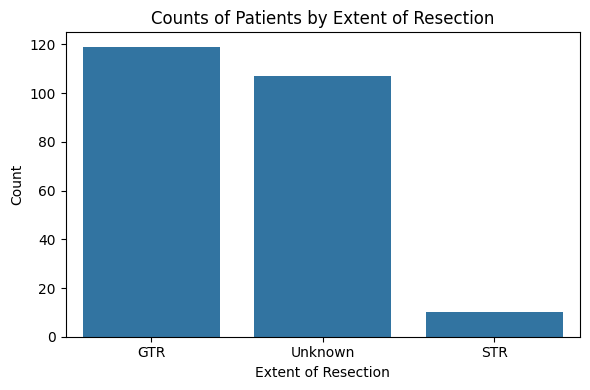

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=cleanSurvivalTrain, x="Extent_of_Resection", order=cleanSurvivalTrain["Extent_of_Resection"].value_counts().index)
plt.title("Counts of Patients by Extent of Resection")
plt.xlabel("Extent of Resection")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Stratify Survival Based on Extent of Resection

We also split survival information by the extent of resection to better understand how surgical intervention may affect survival outcomes. Patients with partial resection lived significantly longer on average, with a mean of 637 days, or 1.74 years, compared to 446 days, which is approximately 1.2 years, for complete resection. The minimum number of days for partial resection was 80 while the minimum survival rate for full resection was 12 days. Similarly, the upper quartile boundary for GTR is 567 days or 1.5 years while the boundary for STR is 897, 2.5 years. These results are reflected in the boxplot of survival times stratified by the extent of resection. The figures suggest that partial resection may result in better outcomes compared to total resection, though this interpretation should be interpreted cautiously and may not be valid.

 Considering that the results for complete resection are similar to those of the Unknown category and medical consensus suggests that GTR results in better outcomes, it is plausible that with only ten instances in the STR category, the sample may not be large enough to fully represent the general population. This suggests that the extent of resection field may contain too much noise to be an insightful variable within the scope of this research as it may generate misleading results.

In [ ]:
summaryTable = cleanSurvivalTrain.groupby("Extent_of_Resection")["Survival_days"].describe().round(0)
print(summaryTable)

                     count   mean    std   min    25%    50%    75%     max
Extent_of_Resection                                                        
GTR                  118.0  446.0  345.0  12.0  192.0  374.0  567.0  1767.0
STR                   10.0  637.0  321.0  80.0  436.0  652.0  897.0  1020.0
Unknown              107.0  427.0  368.0   5.0  172.0  346.0  538.0  1731.0


<ipython-input-51-80f0f5336a1b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summaryTable = cleanSurvivalTrain.groupby("Extent_of_Resection")["Survival_days"].describe().round(0)


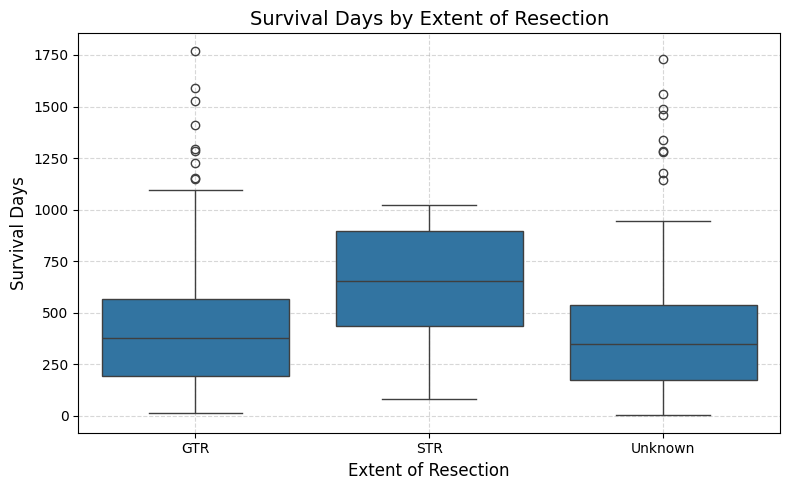

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=cleanSurvivalTrain, x="Extent_of_Resection", y="Survival_days", order=["GTR", "STR", "Unknown"])
plt.title("Survival Days by Extent of Resection", fontsize=14)
plt.xlabel("Extent of Resection", fontsize=12)
plt.ylabel("Survival Days", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Stratify Survival by Age

Next we stratify the surival information by age to see if there are trends within different age brackets. To do this, we bin the Age field in groups of a decade to turn it into a categorical variable. The boxplots show a very clear trend of decreased survival time as age increases, with the exception that patients in their 30's tend to live slightly longer than younger patients. However, the spread of survival rate also increases with age up until age 70. While the average survival time may decrease, several people are able to live longer lives after surgery. This is shown by the greater number of upper boundary outliers as age increases. From age 70 this trends starts to decrease indicating shorter survival time for the majority of patients after this age.

In [ ]:
ageBins = [0, 30, 40, 50, 60, 70, 80, 100]
ageLabels = ["<30", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
cleanSurvivalTrain["AgeGroup"] = pd.cut(cleanSurvivalTrain["Age"], bins=ageBins, labels=ageLabels)

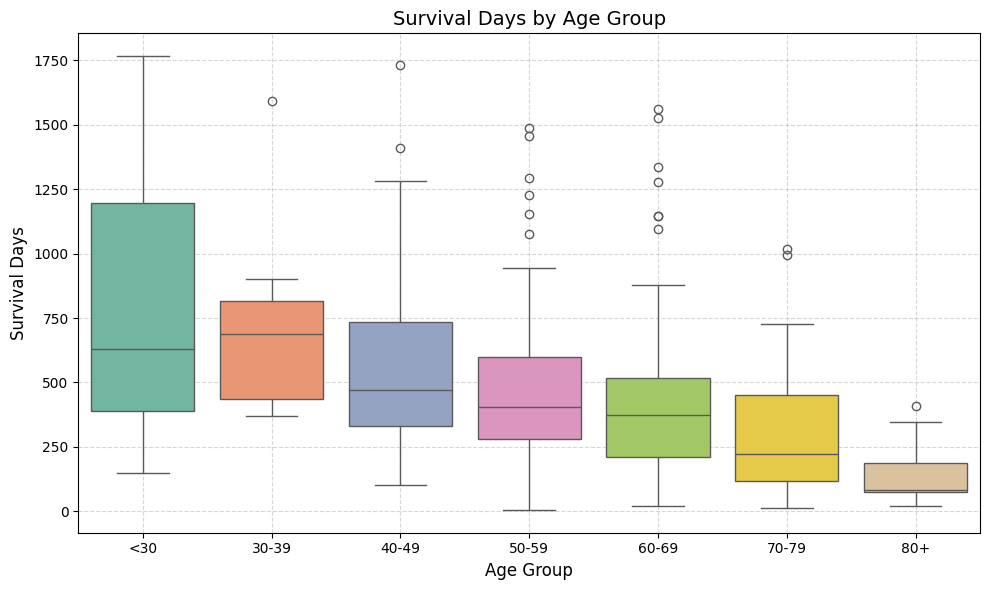

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleanSurvivalTrain, x="AgeGroup", y="Survival_days", palette="Set2", hue="AgeGroup")
plt.title("Survival Days by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Survival Days", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Feature Engineering: Categorical Survival Field**

Following a similar logic as in [3], we can segment patients into short, medium and long survival times. This provides a helpful clinical shorthand for communicating expected outcomes. Patients are classified as short survivors if they live less than 10 months, medium survivors if they live between 10 and 15 months and long survivors if their survival rate exceeds 15 months. This can be approximately represented as:

- Less than 300 days (< *10 months*)
- Between 300 and 450 days (*10 - 15 months*)
- Longer than 450 days (> *15 months*)

We define a function, `survivalThreeCat()`, to segment the data which we then call on the dataset. The distribution of patients across the different survival categories is relatively balanced which is clearly shown in the histogram of the distribution of counts across categories. The results show patients tend to survive for a relatively short or a relatively long period, with fewer patients surviving for an intermediate length of time. Of the patients for which survival data is available, 89 patients are classified as short survivors while 88 patients are classified as long survivors. In contrast, only 59 patients are classified as medium term survivors.


In [ ]:
def survivalThreeCat(days):
    if days < 300:
        return "Short-survivor"
    elif 300 <= days <= 450:
        return "Mid-survivor"
    else:
        return "Long-survivor"

In [ ]:
cleanSurvivalTrain["SurvivalCategory"] = cleanSurvivalTrain["Survival_days"].apply(survivalThreeCat)

In [ ]:
print(cleanSurvivalTrain["SurvivalCategory"].value_counts())

SurvivalCategory
Short-survivor    89
Long-survivor     88
Mid-survivor      59
Name: count, dtype: int64


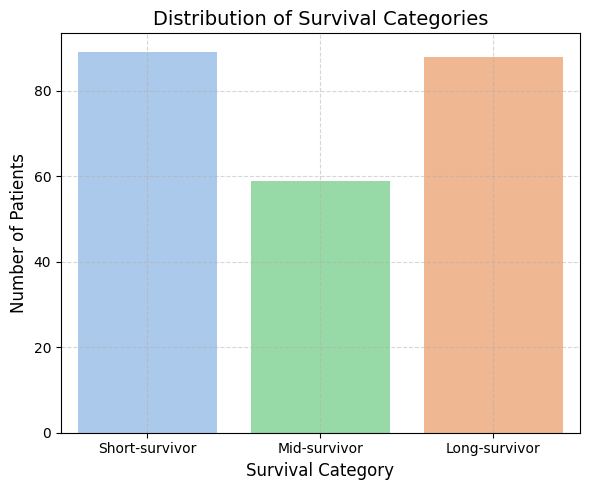

In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(data=cleanSurvivalTrain, x="SurvivalCategory", hue="SurvivalCategory",
    order=["Short-survivor", "Mid-survivor", "Long-survivor"], palette="pastel",dodge=False,legend=False)
plt.title("Distribution of Survival Categories", fontsize=14)
plt.xlabel("Survival Category", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Outliers

Age contains five outliers, while survival days includes 15 outliers. The boxplots reveal that most age outliers tend to be for particularly young patients, which is plausible considering that brain cancer is less likely to appear in young people. The survival days outliers appear in the upper boundaries, suggesting that a few people live significantly longer than others. Again, this is a realistic outcome given genetic variability and the variety of health factors that contribute to survival.

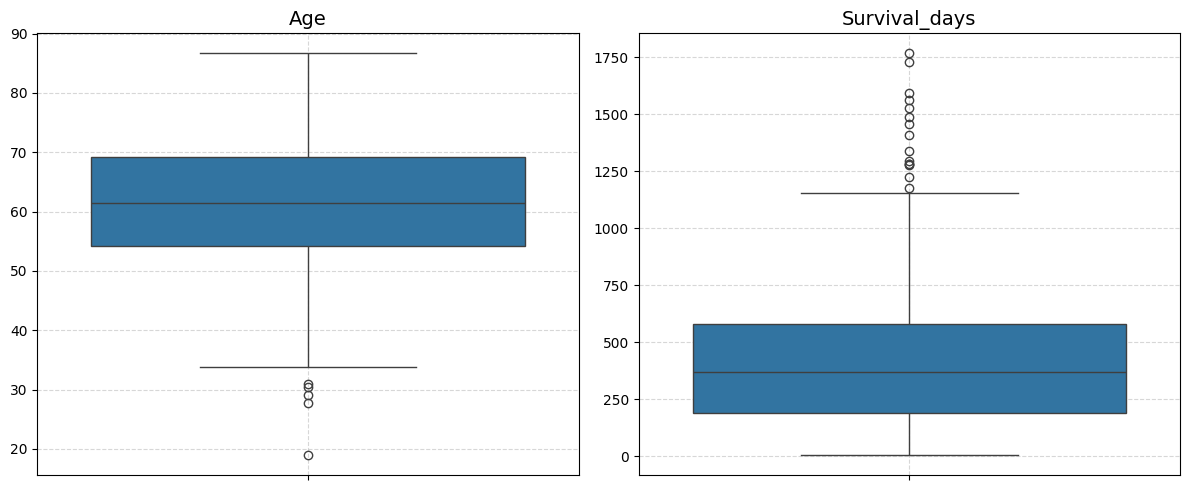

In [ ]:
# box plots to illustrate outliers
plt.figure(figsize=(12, 5))
for i, col in enumerate(["Age", "Survival_days"]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=cleanSurvivalTrain[col])
    plt.title(f"{col}", fontsize=14)
    plt.ylabel("")
    plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

In [ ]:
for col in ["Age", "Survival_days"]:
    outlierMask = outliers(cleanSurvivalTrain[col])
    count = outlierMask.sum()
    print(f"{col}: {count} outliers")

Age: 5 outliers
Survival_days: 15 outliers


---
---
# Inspect Visual Data
---

In order to better understand the dataset we view the MRI details for Patient 001.

---
### Plot Each Modality
---

In [ ]:
# Define patient ID and path
patientId = "BraTS20_Training_001"
patientPath = os.path.join(trainPath, patientId)

We define the modalities we want to visualise for Patient 001, specifically FLAIR, T1, T1CE, T2 and Segmentation. We also create a mapping to display the full names for each modality in the plots.

In [ ]:
modalities = ["flair", "t1", "t1ce", "t2", "seg"]
modalitiesFull = {"flair": "FLAIR","t1": "T1","t1ce": "T1CE","t2": "T2","seg": "Segmentation"}

Below we visualise a single, central slice from each MRI modality and display them side by side. To do this we loop through each modality and build the filename for each modality using the patient ID and modality name e.g. `f"{patientId}_{modality}.nii"` becomes `BraTS20_Training_001_flair.nii`. We use that to constructs the full file path to the NIfTI file for that modality.

We load the MRI volume from the NIfTI file using the `nibabel` library, find the index of the middle slice along the axial plane, extract the 2D image slice and display each slice in a single row.


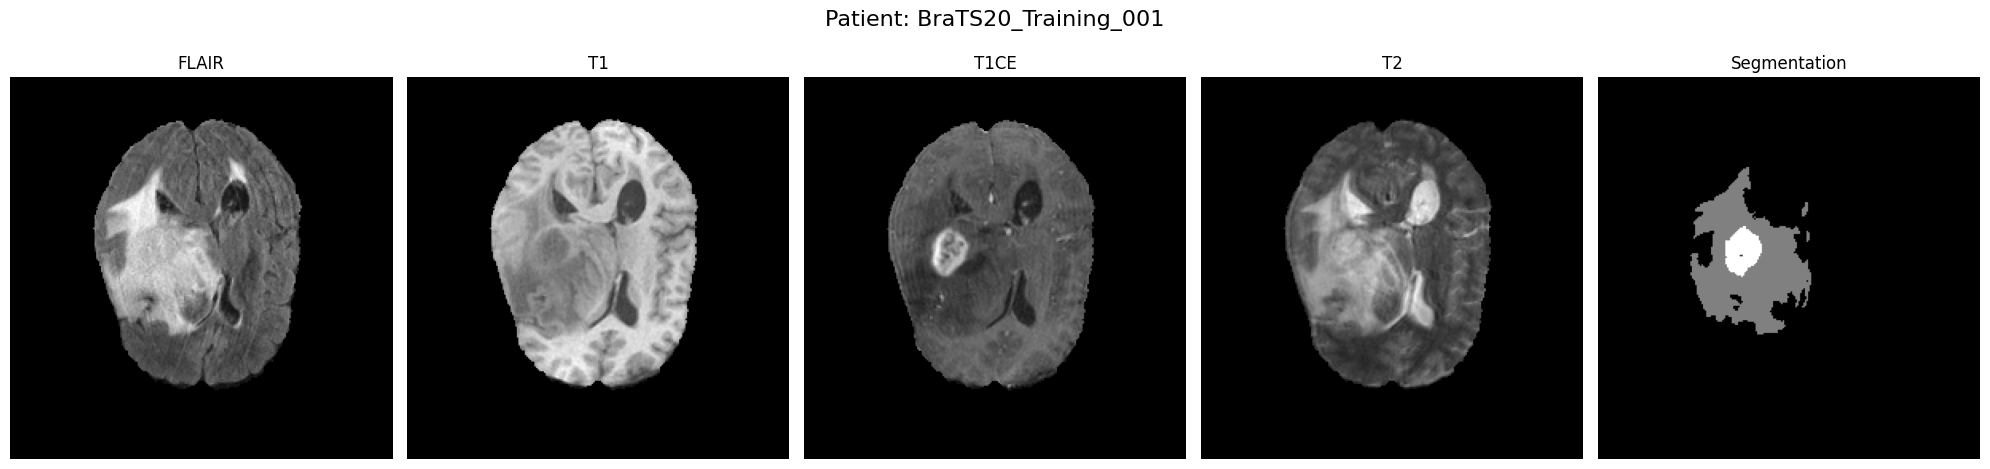

In [ ]:
plt.figure(figsize=(20, 5))
for i, modality in enumerate(modalities):
    fileName = f"{patientId}_{modality}.nii"
    filePath = os.path.join(patientPath, fileName)

    # Load the volume and select the center slice
    volume = nib.load(filePath).get_fdata()
    midSlice = volume.shape[2] // 2
    sliceData = volume[:, :, midSlice]

    plt.subplot(1, len(modalities), i+1)
    plt.imshow(sliceData.T, cmap='gray', origin='lower')
    plt.title(modalitiesFull[modality])
    plt.axis('off')

plt.suptitle(f"Patient: {patientId}", fontsize=16)
plt.tight_layout()
plt.show()

### Plot the modalities with the segmentation mask overlaid

It is easier to identify the tumour by overlaying the segmentation masks. We do this by specifying a semi-transparent RGB colour map for each class label where red corresponds to label 1, the necrotic and non-enhancing tumour core, green corresponds to edema and yellow corresponds to the enhancing tumour.

In [ ]:
# create RGB colour map
colours = [(0, 0, 0, 0), (1, 0, 0, 0.6), (0, 1, 0, 0.6), (0, 0, 1, 0.6), (1, 1, 0, 0.6)]
customCmap = ListedColormap(colours)

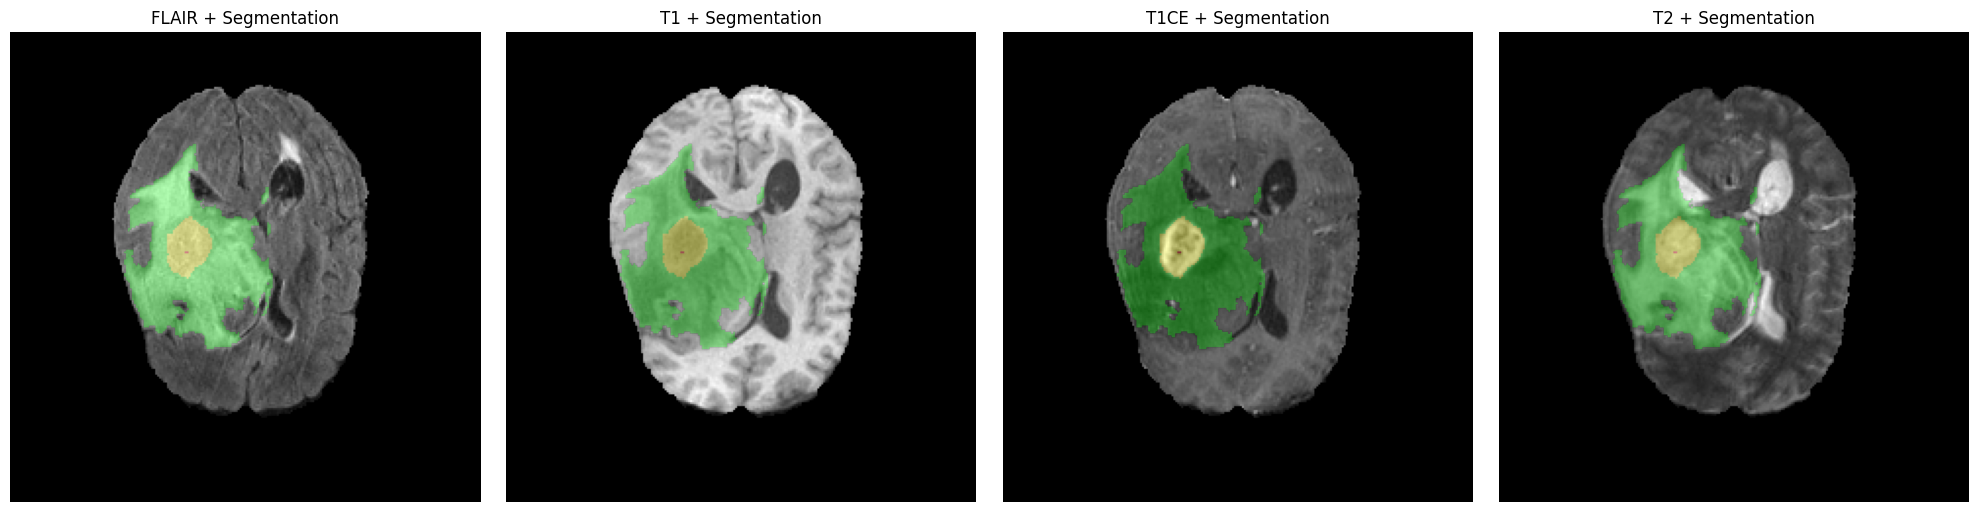

In [ ]:
# segmentation
segPath = os.path.join(patientPath, f"{patientId}_seg.nii")
segVolume = nib.load(segPath).get_fdata()
midSlice = segVolume.shape[2] // 2
segSlice = segVolume[:, :, midSlice]
# overlay for each modality
plt.figure(figsize=(20, 5))
for i, modality in enumerate(["flair", "t1", "t1ce", "t2"]):
    imgPath = os.path.join(patientPath, f"{patientId}_{modality}.nii")
    img = nib.load(imgPath).get_fdata()
    imgSlice = img[:, :, midSlice]
    plt.subplot(1, 4, i+1)
    plt.imshow(imgSlice.T, cmap="gray", origin="lower")
    plt.imshow(segSlice.T, cmap=customCmap, origin="lower", alpha=0.5)
    plt.title(f"{modality.upper()} + Segmentation")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Visualise Perspectives

We can view the MRI from different orientations by extracting the central slice of the axial, coronal and sagittal planes. To do this, we load the T1CE modality for Patient 001 and extract the central slice along each of the three axes, identified by index 0 through 2. We then plot these slices next to one another in grayscale.

In [ ]:
# extract MRI
t1cePath = os.path.join(trainPath, "BraTS20_Training_001", "BraTS20_Training_001_t1ce.nii")
volume = nib.load(t1cePath).get_fdata()
# normalise
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
# extract central slice for each axis
midX = volume.shape[0] // 2
midY = volume.shape[1] // 2
midZ = volume.shape[2] // 2

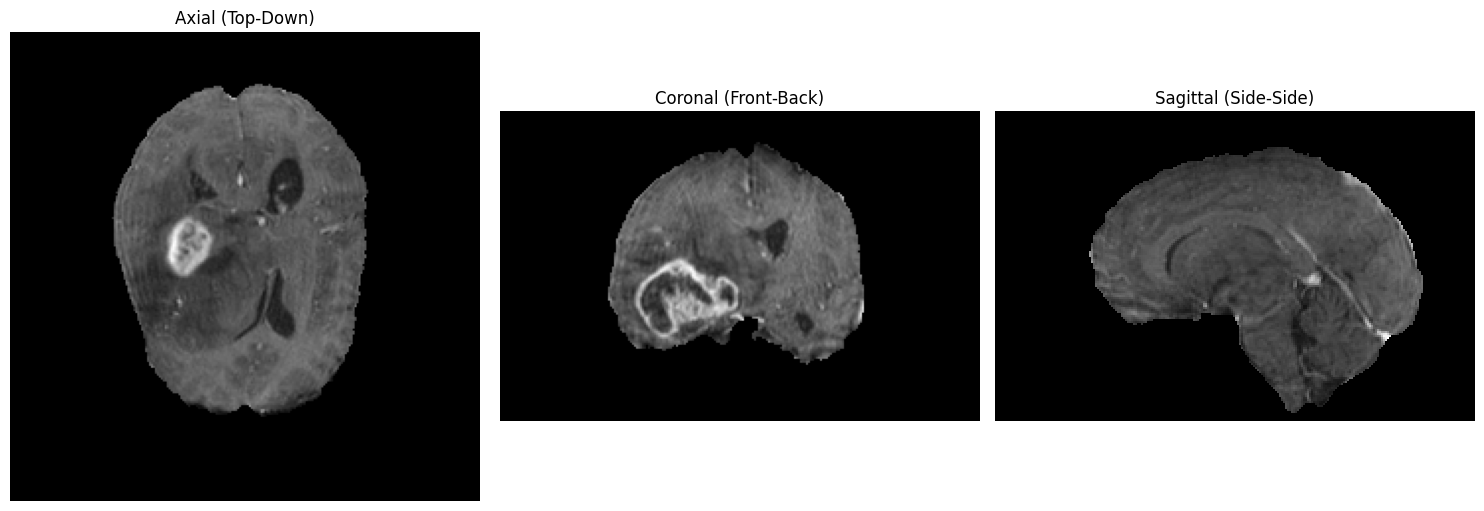

In [ ]:
plt.figure(figsize=(15, 5))
# Axial
plt.subplot(1, 3, 1)
plt.imshow(volume[:, :, midZ].T, cmap="gray", origin="lower")
plt.title("Axial (Top-Down)")
plt.axis("off")
# Coronal
plt.subplot(1, 3, 2)
plt.imshow(volume[:, midY, :].T, cmap="gray", origin="lower")
plt.title("Coronal (Front-Back)")
plt.axis("off")
# Sagittal
plt.subplot(1, 3, 3)
plt.imshow(volume[midX, :, :].T, cmap="gray", origin="lower")
plt.title("Sagittal (Side-Side)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Interactive 3D Visualisation

To get a better sense of the MRIs in 3D space we can create an interactive 3D plot of the brain. The tumour region shows up as a dark mass near the centre of the brain. We normalise and clip the values to be between 0.05 and 0.6 so that they show on the 3D visualisation. We then create a 3D isosurface using Plotly.

In [ ]:
t1cePath = os.path.join(trainPath, "BraTS20_Training_001", "BraTS20_Training_001_t1ce.nii")
t1ceImg = nib.load(t1cePath).get_fdata()
t1ceNorm = (t1ceImg - np.min(t1ceImg)) / (np.max(t1ceImg) - np.min(t1ceImg) + 1e-8)
t1ceClipped = np.clip(t1ceNorm, 0.05, 0.6)

In [ ]:
x, y, z = np.mgrid[
    0:t1ceClipped.shape[0],
    0:t1ceClipped.shape[1],
    0:t1ceClipped.shape[2]]
fig = go.Figure(data=go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=t1ceClipped.flatten(),
    isomin=0.08,
    isomax=0.6,
    surface_count=1,
    caps=dict(x_show=False, y_show=False, z_show=False),
    colorscale='Gray',
    opacity=0.5))

> Please note that due to upload size limitations on VLE the outputs for the 3D visualisation section below were removed.

In [ ]:
fig.update_layout(
    title="3D Isosurface of T1CE MRI",
    scene=dict(
        aspectmode="cube",
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        bgcolor="white" ),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, b=0, t=10))

fig.show()

### GIF of the Saggital Axis

We create a GIF of the sagittal perspective to see the brain through this side. First we extract and normalise the slices in the saggital axis.

In [ ]:
t1Path = os.path.join(trainPath, "BraTS20_Training_001", "BraTS20_Training_001_t1.nii")
volume = nib.load(t1Path).get_fdata()
volume = np.clip(volume, 0, np.percentile(volume, 99))
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

In [ ]:
gifFolder = os.path.join(WORKING_DIR, "GIFs")
os.makedirs(gifFolder, exist_ok=True)
savePath = os.path.join(gifFolder, "T1_sagittal.gif")

 We loop through the sagittal slices and create an image for each slice, clean it and save the result to `frames`. We then save the result which is then played at a speed of 0.1 seconds per frame.

In [ ]:
# Create frames
frames = []
for i in range(20, volume.shape[0]-20, 2):
    plt.figure(figsize=(5,5))
    plt.imshow(volume[i, :, :].T, cmap="gray", origin="lower")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("temp_frame.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    frames.append(imageio.imread("temp_frame.png"))
imageio.mimsave(savePath, frames, duration=0.1, loop=0)

<ipython-input-69-f53310e123b2>:23: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



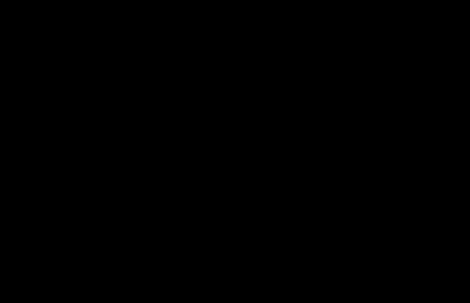

In [ ]:
display(Image(filename=savePath))

---
---
# Voxel Volumes
---

### Illustration of a Single Example
We can calculate the volume of the physical tumour and affected site using the MRI information. MRI data is made up of voxels and the volume of a segmented region is determined by the count of the voxels assigned to that region [1].

To illustrate how we calculate this, we will calculate the tumour and affected site volumes for the first training instance. The size of a single voxel along each axis is stored as metadata in the NIfTI file header which we can extract. We can see that each voxel is exactly 1 x 1 x 1 mm stored as a tuple of (1, 1, 1). We calculate the product of the dimensions to get the volume of a single voxel which is 1mm$^3$.

In [ ]:
# extract and display voxel dimensions
individualDim =nib.load(segPath).header.get_zooms()
individualDim

(np.float32(1.0), np.float32(1.0), np.float32(1.0))

In [ ]:
# calculate voxel volume
voxelVolume = np.prod(individualDim)
voxelVolume

np.float32(1.0)

### Calculate All Voxel Volumes

Next we calculate the number of unique voxel volume for a single patient. The labels refer to different regions in the segmentation mask:

- 0: Background
- 1: Necrotic tumour core
- 2: Edema
- 4: Enhancing tumour

We do not have a label for `3` because this mask was not included in the 2020 BRATS dataset. This is further explain in the section *Class Label Remapping*. We do not need to multiply the values by the voxel volume in this illustrative example as the volume is 1mm$^3$, however, this is done when calculating voxel volumes across the dataset as it is possible for the volume of a single voxel to differ across MRI images. This is because the MRIs have been collected from different sources and there might be slight differences between how a single voxel dimension is calculated [3].

In [ ]:
unique, counts = np.unique(segVolume, return_counts=True)
voxelCounts = dict(zip(unique, counts))

In [ ]:
voxelCounts

{np.float64(0.0): np.int64(8716021),
 np.float64(1.0): np.int64(15443),
 np.float64(2.0): np.int64(168794),
 np.float64(4.0): np.int64(27742)}

---
---
# Project Scope
---

At this point in the research it is worth reflecting on the research questions available to us:

> 1. Generating tumour segmentation masks
2. Predicting tumour volumes using MRI images
3. Predicting whether the patient has high grade glioma vs. low grade glioma
4. Survival prediction based on MRI images or tumour volumes

It is possible to address the first three research questions using a single dataset, `gradeAndVolume`, as we have information for the entire training set for these questions. As the dataset includes survival information for 64% of the training data, we would need to create a new training, test and validation set to include this question in the research. To keep the scope of the research within a focused and manageable level, we will address the first question using a single test, train and validation split.












---
---
# Create 2D MRI Dataset
---

Working with 3D MRI images is computationally expensive. In order to make effective use of the available information while reducing the computational load of the dataset, we create a 2D dataset from the 3D MRI data by extracting the five middle axial slices to create five separate instances. This is a type of data augmention which increases the sample size from 358 instances to 1790. For each instance the T1CE, T2 and FLAIR files are used, which creates a 3 channel dataset of size 240 x 240 x 3. Each image is downsampled to 128 x 128 resulting in a dimension of (128, 128, 3) per instance and (128, 128, 3, 1790) overall. This process is illustrated in the figure below.



<center>
  <figure>
    <img src="https://i.imgur.com/qVVMepd.png" >
    <figcaption>Diagram of Data Preprocessing</figcaption>
  </figure>
</center>


Before running the loop to extract and compile the dataset, we define the T1CE, T2 and FLAIR modalities we are interested in, the desired downsampled image size, and the number of slices we extract per patient. We then initialise accumulator variables to collect the data as it is processed. Specifically, the features, the modalities,  targets and the segmentation mask.

In [ ]:
# Define parameters
modalities = ["t1ce", "t2", "flair"]
targetSize = (128, 128)
nSlices = 5

In [ ]:
# initialise accumulators
XData = []
YData = []

### Creating the 2D Dataset

The dataset is created using a `for` loop which iterates through each ID name in the `gradeAndVolume` dataframe created earlier and extracts the full 3D file for each modality. If a patient folder is missing specific modalities, it skips that patient.

To extract the number of axial slices, we extract the size of the third dimension via `modImg.shape[2]`. We divide this value by 2 to get the middle slice indices and then create a range from the two indices below the middle slice to the two indices above.

In order to extract the actual image slices we extract the five indice slices along the third, axial, axis of the 3D array. To normalise the slices we clip the intensity values to between zero and the 99th percentile of the slice's intensity values. We use min-max normalisation to set the values between `0` and `1`. We do this by subtracting the minimum slice value from each slice and dividing this value by the range of the slice values. This is shown as:

$$
\frac{\text{slice} - \text{min}}{\text{max}-\text{min}}
$$

We use linear interpolation to reduce the slice from 240 x 240 pixels to 128 x 28 pixels. This method takes the four nearest neighbouring pixels to compute a weighted average value. The slices for all modalities are stacked along the last axis, which gives us a 3D array where each modality's slice is a different channel. This results in the shape `(128, 128, 3)` for each instance.

The segmentation masks, the ground truth targets, are then extracted using the same method as the features. However, normalisation and scaling are not performed on the masks. The masks are resized to 128 x 128, though, using nearest neighbour interpolation. This method assigns the value of the closest original pixel to the new pixel. We don't use averaging here in order to preserve the different class values. The masks and modalities are then saved to `XData` and `YData`.

In [ ]:
for idx, patientId in enumerate(gradeAndVolume["Brats20ID"]):
    patientPath = os.path.join(trainPath, patientId)
    # extract modalities
    modalitySlices = []
    for mod in modalities:
        modPath = os.path.join(patientPath, f"{patientId}_{mod}.nii")
        if not os.path.exists(modPath):
            print(f"Missing {mod}, skipping {patientId}")
            break
        modImg = nib.load(modPath).get_fdata()
        # get slice indices
        midSlice = modImg.shape[2] // 2
        sliceIndices = range(midSlice - nSlices//2, midSlice + nSlices//2 + 1)
        # extract & normalise slices
        for i in sliceIndices:
            slice2D = modImg[:, :, i]
            slice2D = np.clip(slice2D, 0, np.percentile(slice2D, 99))
            slice2D = (slice2D - np.min(slice2D)) / (np.max(slice2D) - np.min(slice2D))
            slice2D = cv2.resize(slice2D, targetSize, interpolation=cv2.INTER_LINEAR)
            modalitySlices.append(slice2D)
    # stack modalities & skip missing / corrupt entries
    if not modalitySlices:
        continue
    modalitySlices = np.stack(modalitySlices, axis=-1)
    # create segmentation masks
    segPath = os.path.join(patientPath, f"{patientId}_seg.nii")
    if not os.path.exists(segPath):
        print(f"Missing. Skipped {patientId}")
        continue
    segImg = nib.load(segPath).get_fdata()

    maskSlices = []
    for i in sliceIndices:
        mask2D = segImg[:, :, i]
        mask2D = cv2.resize(mask2D, targetSize, interpolation=cv2.INTER_NEAREST)
        maskSlices.append(mask2D)
    maskSlices = np.stack(maskSlices, axis=0)

    # Extract slices & assign to variables
    for j in range(nSlices):
        XData.append(modalitySlices[:, :, j*3:(j+1)*3])
        YData.append(maskSlices[j, :, :])

This results in the following variables:
- `XData` with dimensions `(N, 128, 128, 3)`  
- `YData` with dimensions `(N, 128, 128)`  

We convert these to numpy arrays and save them to the directory as compressed `.npz` files.


In [ ]:
XData = np.array(XData)
YData = np.array(YData)

### Class Label Remapping



As described earlier, the class labels for segmentation currently correspond to the follwing regions:

- Label 0: Background
- Label 1: Necrotic and non-enhancing tumor core

- Label 2: Peritumoral edema

- Label 4: Enhancing tumor

There’s no class label 3 which has been eliminated since the 2017 version of BraTS. Label 3 previously referred to the non-enhancing tumour core but manual annotators and machine learning algorithms alike struggled to consistently identify this region. Because of this, the region was combined with the tumour necrotic core [3]. We remap label 4 to label 3 to keep the labels sequential. This way, we have four consecutive which is easier for the model to handle. After remapping the class labels are:

- Label 0: Background
- Label 1: Necrotic and non-enhancing tumor core

- Label 2: Peritumoral edema

- Label 3: Enhancing tumor

In [ ]:
YData[YData == 4] = 3
print(np.unique(YData))

[0. 1. 2. 3.]


### One-hot Encoding the Segmentation Masks
One-hot encoding is a method for representing categorical labels as binary vectors. Each class is represented by a vector where the number of elements equals the number of class labels and for each class label one element is set to 1 and all others are 0. This allows the network to output probabilities for each class which makes the loss function calculation straightforward during machine learning tasks.

In [ ]:
YDataCat = tf.keras.utils.to_categorical(YData, num_classes=4)
print(YDataCat.shape)

(1840, 128, 128, 4)


Confirm the dataset shapes.




In [ ]:
print("X shape:", XData.shape)
print("Y shape:", YData.shape)
print("Y Cat shape:", YDataCat.shape)
print(f"X dtype: {XData.dtype}, Y dtype: {YData.dtype}, Y Cat dtype: {YDataCat.dtype}")

X shape: (1840, 128, 128, 3)
Y shape: (1840, 128, 128)
Y Cat shape: (1840, 128, 128, 4)
X dtype: float64, Y dtype: float64, Y Cat dtype: float64


We then save the results to `Processed2DData`.

In [ ]:
saveFolder = os.path.join(WORKING_DIR, "Processed2DData")
os.makedirs(saveFolder, exist_ok=True)

In [ ]:
np.savez_compressed(os.path.join(saveFolder, "dataset2D.npz"), X=XData, Y=YDataCat)

---
---
# Data Split
---

The data is split into test, train and validation sets using a 70-15-15 split. This is done using the `train_test_split()` function from scikit learn.

In [ ]:
XTrainVal, XTest, YTrainValCat, YTestCat = train_test_split(XData, YDataCat, test_size=0.15,random_state=101)
XTrain, XVal, YTrainCat, YValCat = train_test_split(XTrainVal, YTrainValCat, test_size=0.1765, random_state=101)

We confirm the shape of each data subset.

In [ ]:
print(f"Train: X {XTrain.shape}, Y {YTrainCat.shape}")
print(f"Val: X {XVal.shape}, Y {YValCat.shape}")
print(f"Test: X {XTest.shape}, Y {YTestCat.shape}")

Train: X (1287, 128, 128, 3), Y (1287, 128, 128, 4)
Val: X (277, 128, 128, 3), Y (277, 128, 128, 4)
Test: X (276, 128, 128, 3), Y (276, 128, 128, 4)


We save the test, train and validation sets.

In [ ]:
np.savez_compressed(os.path.join(saveFolder, "train.npz"), X=XTrain, Y=YTrainCat)
np.savez_compressed(os.path.join(saveFolder, "val.npz"), X=XVal, Y=YValCat)
np.savez_compressed(os.path.join(saveFolder, "test.npz"), X=XTest, Y=YTestCat)

---
---
# Process Unlabelled Data
---

We process the unlabelled data using the same method as the labelled XData. We do not process the segmentation masks, as there are none. When creating a 2D dataset on the unlabelled data we found that some image files were missing or corrupted. The code was then edited to skip patients with missing or corrupted files.

In [ ]:
unlabelledPath = os.path.join(WORKING_DIR,"BRATS20", "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

We extract the patient IDs of the unlabelled dataset by extracting the folder titles from the validation set. The names are initially unsorted so we sort the list before generating a 2D dataset from the MRI image files.

In [ ]:
unlabelledPatients = [f for f in os.listdir(unlabelledPath) if f.startswith("BraTS20_Validation")]

The patient IDs are unsorted so we sort them in ascending order before processing.

In [ ]:
unlabelledPatients[:5]

['BraTS20_Validation_009',
 'BraTS20_Validation_002',
 'BraTS20_Validation_004',
 'BraTS20_Validation_017',
 'BraTS20_Validation_010']

In [ ]:
unlabelledPatients.sort()

In [ ]:
unlabelledPatients[:5]

['BraTS20_Validation_001',
 'BraTS20_Validation_002',
 'BraTS20_Validation_003',
 'BraTS20_Validation_004',
 'BraTS20_Validation_005']

In [ ]:
XUnlabelled = []

We process the unlabelled 2D dataset using the same process as before.

In [ ]:
for patientId in unlabelledPatients:
    patientPath = os.path.join(unlabelledPath, patientId)
    modalitySlices = []

    for mod in modalities:
        modPath = os.path.join(patientPath, f"{patientId}_{mod}.nii")
        if not os.path.exists(modPath) or os.path.getsize(modPath) == 0:
            print(f"Missing or empty {mod} for {patientId}, skipping.")
            modalitySlices = []
            break
        volume = nib.load(modPath).get_fdata()
        midSlice = volume.shape[2] // 2
        sliceIndices = range(midSlice - nSlices // 2, midSlice + nSlices // 2 + 1)

        for i in sliceIndices:
            slice2D = volume[:, :, i]
            slice2D = np.clip(slice2D, 0, np.percentile(slice2D, 99))
            slice2D = (slice2D - np.min(slice2D)) / (np.max(slice2D) - np.min(slice2D) + 1e-8)
            slice2D = cv2.resize(slice2D, targetSize, interpolation=cv2.INTER_LINEAR)
            modalitySlices.append(slice2D)
    if not modalitySlices:
        continue
    modalitySlices = np.stack(modalitySlices, axis=-1)
    for j in range(nSlices):
        XUnlabelled.append(modalitySlices[:, :, j*3:(j+1)*3])

Missing or empty flair for BraTS20_Validation_118, skipping.


In [ ]:
XUnlabelled = np.array(XUnlabelled)

The result is 620 instances of 128 x 128 pixels each with 3 channels, one for each modality.

In [ ]:
print(XUnlabelled.shape)

(620, 128, 128, 3)


In [ ]:
savePath = os.path.join(WORKING_DIR, "XUnlabelled.npz")
np.savez_compressed(savePath, XUnlabelled=XUnlabelled)

Now that we have created our dataset we can proceed to Phases 1, 2 and 3 which are completed in separate notebooks.

---
---